## TensorFlow 2.0 선택
[런타임] -> [런타임 유형변경]에서 하드웨어 가속기를 꼭 GPU로 설정!

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


## Coding Tips
Neural Network coding 시에 아래와 같이 구분하여 만들자
#### 1. Hyper Paramter 정하기
#### 2. Data 준비(불러오기 or download 등)
#### 3. Dataset 구성 (tf.data.Dataset 이용)
#### 4. Modlel 만들기 (Neural Network model)
#### 5. Loss function 정의, Optimizer 선택
#### 6. Training (Train, Test function 만들기 포함)
#### 7. Validation(or Test) 결과 확인

## Importing Libraries

In [2]:
## Library import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.1.0-rc1
2.2.4-tf


## Hyper Parameters

In [0]:
learning_rate = 0.001
training_epochs = 20
batch_size = 100
n_class = 10

## MNIST/Fashion MNIST Data

In [0]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Datasets

In [0]:
## MNIST dataset load
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()  

In [6]:
## train_images, train_labels의 type 확인
type(train_images), type(train_labels)

(numpy.ndarray, numpy.ndarray)

In [7]:
## train_images, train_labels의 shape 확인
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [8]:
## test_images, test_labels의 shape 확인
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

In [9]:
## training set의 각 class 별 image 수 확인
unique, counts = np.unique(train_labels, axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [10]:
## test set의 각 class 별 image 수 확인
unique, counts = np.unique(test_labels, axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

In [11]:
## train dataset, test dataset의 개수 저장
n_train = train_images.shape[0]
n_test = test_images.shape[0]
print('train data 수: ', n_train)
print(' test data 수: ', n_test)

train data 수:  60000
 test data 수:  10000


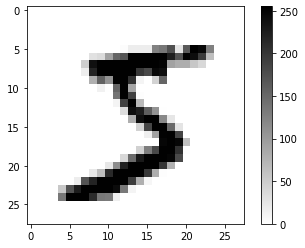

In [12]:
## train_images의 0번 image 화면에 출력
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

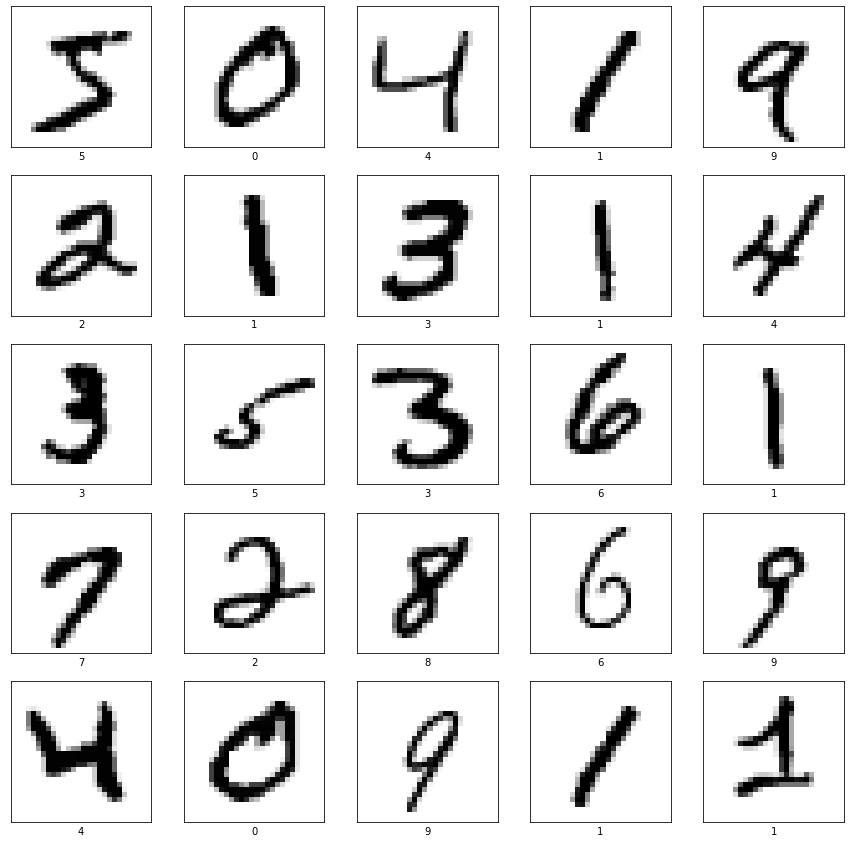

In [13]:
## 25개의 train image와 label 화면에 출력
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [14]:
## image를 0~1사이 값으로 만들기 위하여 255로 나누어줌
print('<nomalizing pixel values>')
print('before: ', train_images[0,13,12:17])
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
print('after:  ', train_images[0,13,12:17])
print()

## one-hot encoding
print('<one-hot encoding>')
print('before: ', train_labels[:5])
train_labels = to_categorical(train_labels, n_class)
test_labels = to_categorical(test_labels, n_class)
print('after:  ', train_labels[:5])

<nomalizing pixel values>
before:  [ 35 241 225 160 108]
after:   [0.13725491 0.94509804 0.88235295 0.627451   0.42352942]

<one-hot encoding>
before:  [5 0 4 1 9]
after:   [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [0]:
## dataset 구성    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Linear Regression Model

In [0]:
def create_lr_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [17]:
lr_model = create_lr_model()
lr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Model Compile(Optimizer & Loss Function)

In [0]:
lr_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

## Training

In [19]:
steps_per_epoch = n_train//batch_size
validation_steps = n_test//batch_size
print('number of steps per epoch: ', steps_per_epoch)
print('number of steps per validation: ', validation_steps) 

number of steps per epoch:  600
number of steps per validation:  100


In [20]:
## traing 전에 loss 및 validation accuracy 확인
lr_model.evaluate(test_dataset, steps=validation_steps)

100/100 [==============================] - 1s 5ms/step - loss: 2.4487 - accuracy: 0.0936


[2.4487420773506163, 0.0936]

In [21]:
history = lr_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 4ms/step - loss: 0.6301 - accuracy: 0.8418 - val_loss: 0.3596 - val_accuracy: 0.9053
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 0.3458 - accuracy: 0.9057 - val_loss: 0.3088 - val_accuracy: 0.9144
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.3097 - accuracy: 0.9143 - val_loss: 0.2874 - val_accuracy: 0.9195
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2924 - accuracy: 0.9183 - val_loss: 0.2785 - val_accuracy: 0.9219
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2818 - accuracy: 0.9207 - val_loss: 0.2731 - val_accuracy: 0.9237
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2745 - accuracy: 0.9236 - val_loss: 0.2757 - val_accuracy: 0.9232
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2694 - accuracy: 0.9248 - va

## Training 결과 확인

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img,cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

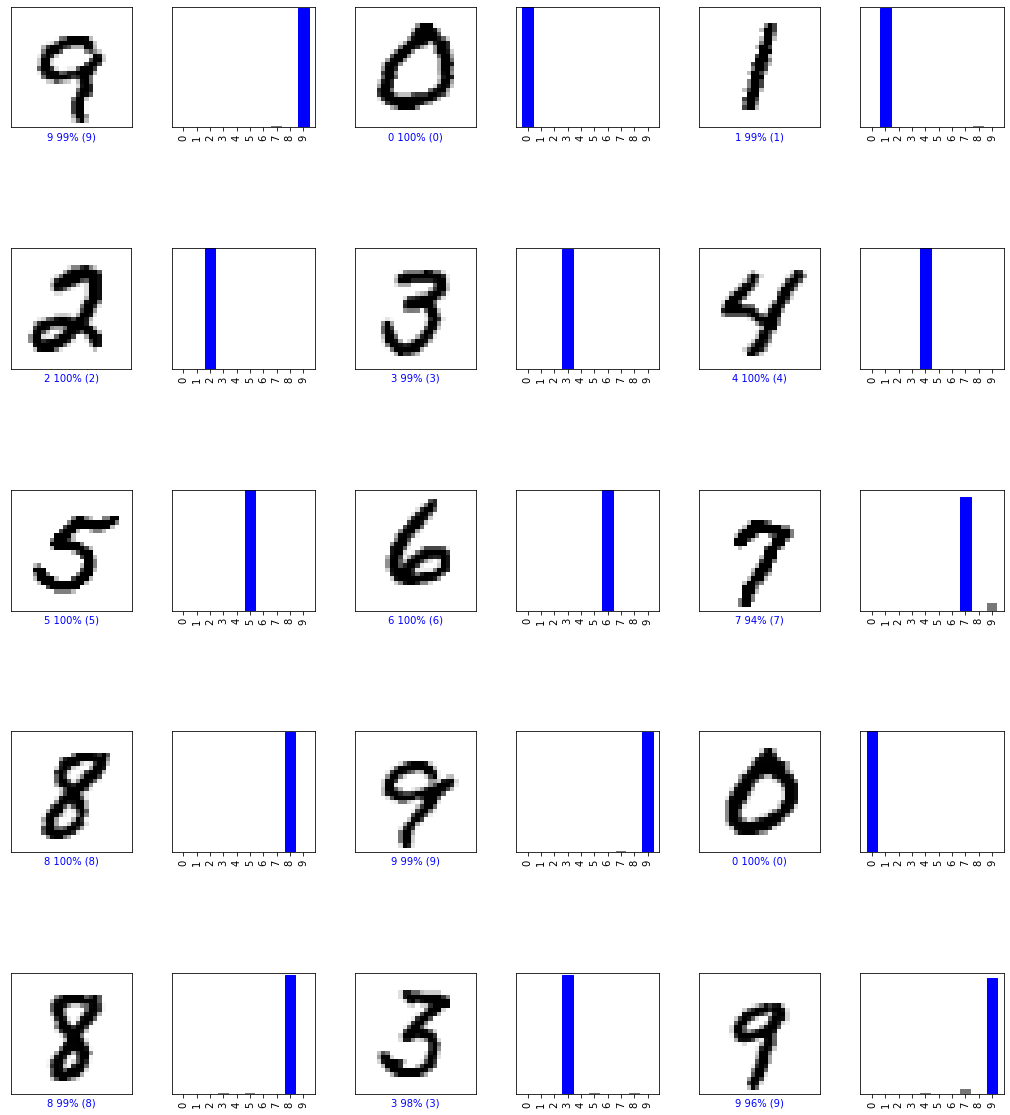

In [23]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = lr_model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

## Multi-Layer Perceptron Model - 3 layers

In [0]:
def create_mlp_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [25]:
mlp_model = create_mlp_model()
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [0]:
## model compile
mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [27]:
## traing 전에 loss 및 validation accuracy 확인
mlp_model.evaluate(test_dataset, steps=validation_steps)

100/100 [==============================] - 0s 3ms/step - loss: 2.3247 - accuracy: 0.1001


[2.324747405052185, 0.1001]

In [28]:
## training
history = mlp_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2550 - accuracy: 0.9261 - val_loss: 0.1165 - val_accuracy: 0.9645
Epoch 2/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0961 - accuracy: 0.9706 - val_loss: 0.0853 - val_accuracy: 0.9744
Epoch 3/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0633 - accuracy: 0.9807 - val_loss: 0.0797 - val_accuracy: 0.9749
Epoch 4/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0455 - accuracy: 0.9858 - val_loss: 0.0764 - val_accuracy: 0.9762
Epoch 5/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0344 - accuracy: 0.9892 - val_loss: 0.0645 - val_accuracy: 0.9802
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.0668 - val_accuracy: 0.9799
Epoch 7/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0224 - accuracy: 0.9929 - va

## Multi-Layer Perceptron Model - 5 layers

In [0]:
def create_dmlp_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))    
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [30]:
dmlp_model = create_dmlp_model()
dmlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
## model compile
dmlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [32]:
## traing 전에 loss 및 validation accuracy 확인
dmlp_model.evaluate(test_dataset, steps=validation_steps)

100/100 [==============================] - 0s 4ms/step - loss: 2.3139 - accuracy: 0.0909


[2.3138637804985045, 0.0909]

In [33]:
## training
history = dmlp_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2479 - accuracy: 0.9274 - val_loss: 0.1201 - val_accuracy: 0.9629
Epoch 2/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0973 - accuracy: 0.9703 - val_loss: 0.0863 - val_accuracy: 0.9738
Epoch 3/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0669 - accuracy: 0.9793 - val_loss: 0.0864 - val_accuracy: 0.9730
Epoch 4/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0487 - accuracy: 0.9848 - val_loss: 0.0745 - val_accuracy: 0.9766
Epoch 5/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0406 - accuracy: 0.9869 - val_loss: 0.0704 - val_accuracy: 0.9799
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0324 - accuracy: 0.9898 - val_loss: 0.0662 - val_accuracy: 0.9797
Epoch 7/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0307 - accuracy: 0.9903 - va

## Drop-out

In [0]:
drop_rate = 0.2

def create_do_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [35]:
do_model = create_do_model()
do_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [0]:
## model compile
do_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [37]:
## traing 전에 loss 및 validation accuracy 확인
do_model.evaluate(test_dataset, steps=validation_steps)

100/100 [==============================] - 0s 3ms/step - loss: 2.2961 - accuracy: 0.0887


[2.2960687279701233, 0.0887]

In [38]:
## training
history = do_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.3626 - accuracy: 0.8885 - val_loss: 0.1402 - val_accuracy: 0.9593
Epoch 2/20
600/600 [==============================] - 3s 4ms/step - loss: 0.1505 - accuracy: 0.9566 - val_loss: 0.0966 - val_accuracy: 0.9698
Epoch 3/20
600/600 [==============================] - 3s 4ms/step - loss: 0.1111 - accuracy: 0.9671 - val_loss: 0.0874 - val_accuracy: 0.9752
Epoch 4/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0951 - accuracy: 0.9725 - val_loss: 0.0750 - val_accuracy: 0.9780
Epoch 5/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0803 - accuracy: 0.9760 - val_loss: 0.0786 - val_accuracy: 0.9774
Epoch 6/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0709 - accuracy: 0.9788 - val_loss: 0.0742 - val_accuracy: 0.9792
Epoch 7/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0637 - accuracy: 0.9817 - va

## Weight Decay (L2 Regulrarization)

In [0]:
reg_weight = 0.00002

def create_l2r_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight),
                                 bias_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight),
                                 bias_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight),
                                 bias_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight),
                                 bias_regularizer=keras.regularizers.l2(reg_weight)))    
    model.add(keras.layers.Dense(10, activation='softmax',
                                kernel_regularizer=keras.regularizers.l2(reg_weight),
                                 bias_regularizer=keras.regularizers.l2(reg_weight)))
    return model

In [40]:
l2r_model = create_l2r_model()
l2r_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
## model compile
l2r_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [42]:
## traing 전에 loss 및 validation accuracy 확인
l2r_model.evaluate(test_dataset, steps=validation_steps)

100/100 [==============================] - 0s 5ms/step - loss: 2.3362 - accuracy: 0.1295


[2.3362202286720275, 0.1295]

In [43]:
## training
history = l2r_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 4s 6ms/step - loss: 0.2645 - accuracy: 0.9259 - val_loss: 0.1481 - val_accuracy: 0.9603
Epoch 2/20
600/600 [==============================] - 3s 4ms/step - loss: 0.1148 - accuracy: 0.9700 - val_loss: 0.1225 - val_accuracy: 0.9682
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0857 - accuracy: 0.9796 - val_loss: 0.1029 - val_accuracy: 0.9759
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0713 - accuracy: 0.9847 - val_loss: 0.1003 - val_accuracy: 0.9758
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0643 - accuracy: 0.9867 - val_loss: 0.0909 - val_accuracy: 0.9800
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0598 - accuracy: 0.9884 - val_loss: 0.0989 - val_accuracy: 0.9785
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0577 - accuracy: 0.9891 - va

## Batch Normalization

In [0]:
def create_bn_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Softmax())
    return model

In [45]:
bn_model = create_bn_model()
bn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               200960    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)              

In [0]:
## model compile
bn_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [47]:
## traing 전에 loss 및 validation accuracy 확인
bn_model.evaluate(test_dataset, steps=validation_steps)

100/100 [==============================] - 0s 5ms/step - loss: 2.3384 - accuracy: 0.0672


[2.338446865081787, 0.0672]

In [48]:
## training
history = bn_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 5s 9ms/step - loss: 0.3832 - accuracy: 0.9382 - val_loss: 0.2040 - val_accuracy: 0.9696
Epoch 2/20
600/600 [==============================] - 4s 7ms/step - loss: 0.1627 - accuracy: 0.9728 - val_loss: 0.1145 - val_accuracy: 0.9761
Epoch 3/20
600/600 [==============================] - 4s 7ms/step - loss: 0.1037 - accuracy: 0.9793 - val_loss: 0.1092 - val_accuracy: 0.9730
Epoch 4/20
600/600 [==============================] - 4s 7ms/step - loss: 0.0761 - accuracy: 0.9843 - val_loss: 0.0842 - val_accuracy: 0.9785
Epoch 5/20
600/600 [==============================] - 4s 7ms/step - loss: 0.0598 - accuracy: 0.9866 - val_loss: 0.0786 - val_accuracy: 0.9781
Epoch 6/20
600/600 [==============================] - 4s 7ms/step - loss: 0.0467 - accuracy: 0.9890 - val_loss: 0.0713 - val_accuracy: 0.9801
Epoch 7/20
600/600 [==============================] - 4s 7ms/step - loss: 0.0399 - accuracy: 0.9902 - va

## Learning Rate Decay

In [49]:
lr_decay_model = create_dmlp_model()
lr_decay_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
## learning rate scheduler - exponential decay
### initial learning rate: 초기 learning rate
### decay_steps: 몇 step 후에 learning rate을 감소시킬 것인지
### decay_rate: learning rate 감소 비율
### staircase: 계단식 감소여부(False일 경우는 매 step마다 감소하여 decay steps에 도달하였을 때 decay_rate만큼 감소됨) 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.3,
                                                          staircase=True)

In [0]:
## model compile
lr_decay_model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [52]:
## traing 전에 loss 및 validation accuracy 확인
lr_decay_model.evaluate(test_dataset, steps=validation_steps)

100/100 [==============================] - 0s 3ms/step - loss: 2.3108 - accuracy: 0.0882


[2.3107838106155394, 0.0882]

In [53]:
## training
history = lr_decay_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2532 - accuracy: 0.9258 - val_loss: 0.1263 - val_accuracy: 0.9594
Epoch 2/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0962 - accuracy: 0.9708 - val_loss: 0.0924 - val_accuracy: 0.9701
Epoch 3/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0655 - accuracy: 0.9798 - val_loss: 0.0960 - val_accuracy: 0.9716
Epoch 4/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0515 - accuracy: 0.9836 - val_loss: 0.0762 - val_accuracy: 0.9756
Epoch 5/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0425 - accuracy: 0.9868 - val_loss: 0.0883 - val_accuracy: 0.9760
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0332 - accuracy: 0.9894 - val_loss: 0.0870 - val_accuracy: 0.9758
Epoch 7/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0285 - accuracy: 0.9910 - va

### Create MY Model

In [0]:
def create_my_model():
    model = keras.Sequential()
    '''model.add를 이용하여 자기만의 model 만들기'''


In [0]:
my_model = create_my_model()
my_model.summary()

In [0]:
## model compile
my_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
## traing 전에 loss 및 validation accuracy 확인
my_model.evaluate(test_dataset, steps=validation_steps)

In [0]:
## training
history = my_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)